In [1]:
%matplotlib inline
from pprint import pprint

import gdal
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import utils
from joblib import dump, load
from matplotlib import colors
from skimage import exposure
from skimage.util import img_as_ubyte
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

sn.set(style="ticks")
plt.style.use("ggplot")

## 1. Image "equalisation"

### 1.1. Histograms

In [2]:
# Area of interest
area = 2

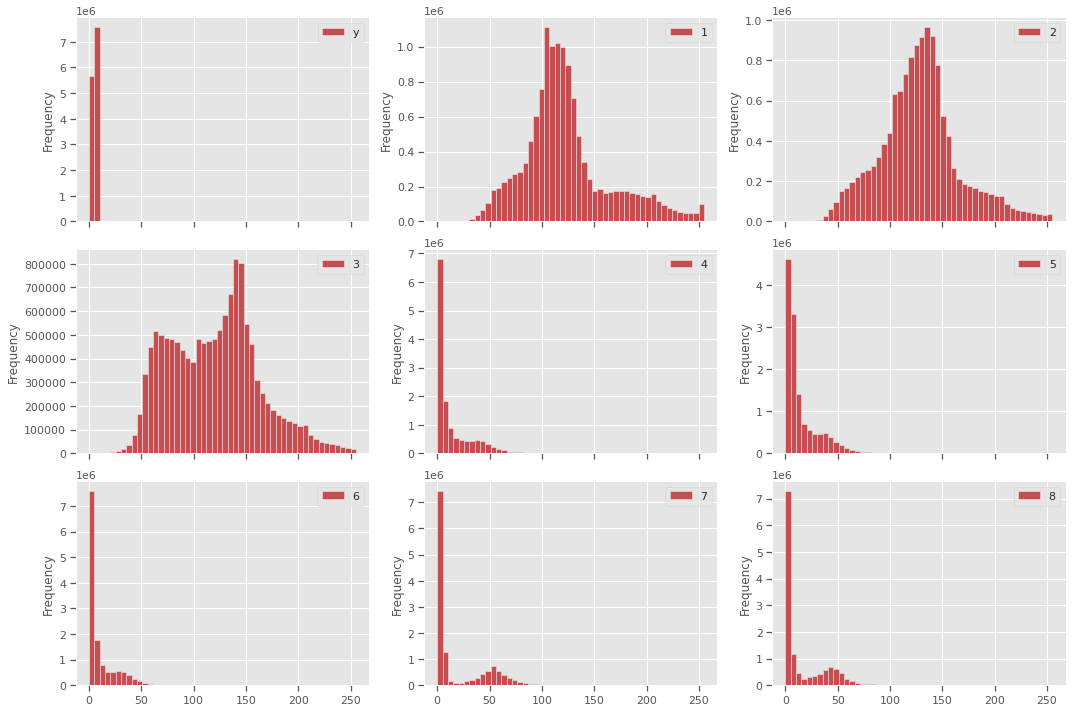

In [3]:
# Without equalisation
df_noeq = utils.image_to_sample_df(area, equalise=False)
df_noeq.plot.hist(bins=50, layout=(3, 3), subplots=True, figsize=(15, 10), color="r")
plt.tight_layout()

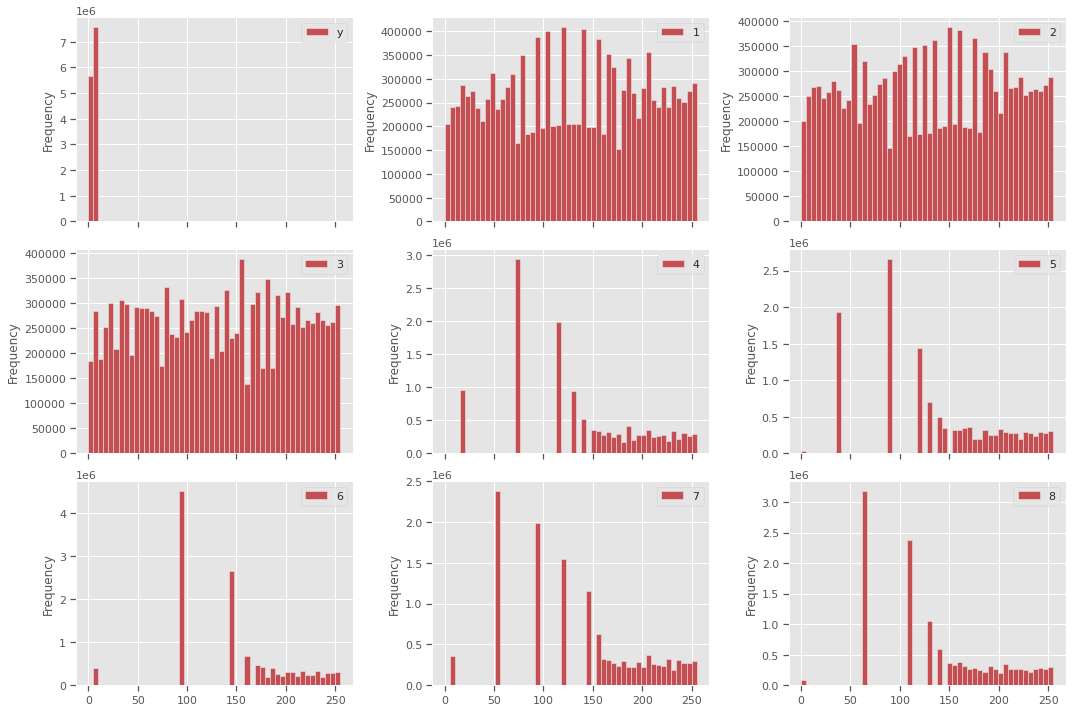

In [4]:
# With equalisation
df_eq = utils.image_to_sample_df(area, equalise=True)
df_eq.plot.hist(bins=50, layout=(3, 3), subplots=True, figsize=(15, 10), color="r")
plt.tight_layout()

### 1.2. RGB image appearance

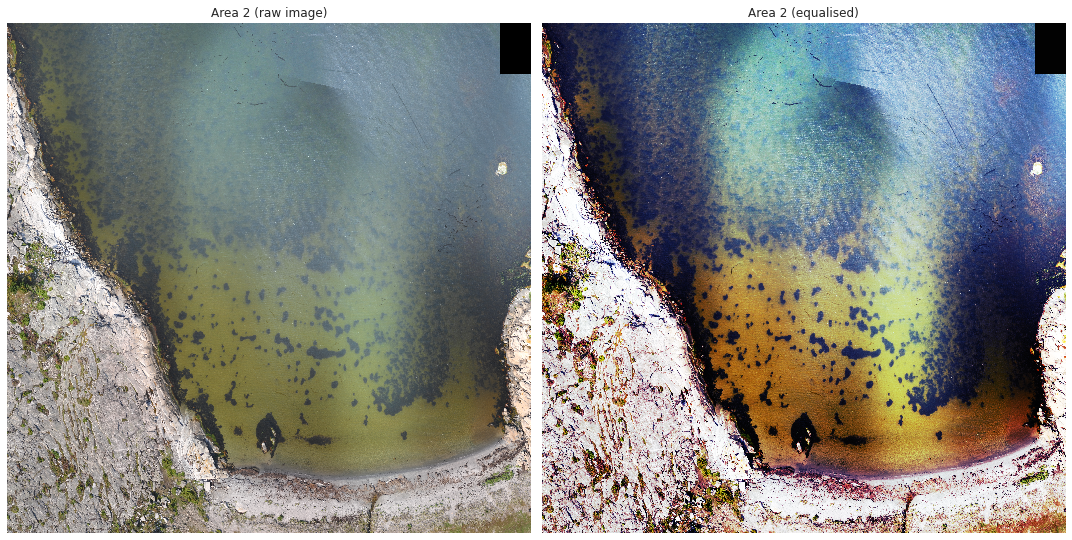

In [5]:
# Path to image
raw_path = (
    f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif"
)

# Read raw RGB bands to arrays
band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)

# Equalise RGB
band1_eq = img_as_ubyte(exposure.equalize_hist(band1))
band2_eq = img_as_ubyte(exposure.equalize_hist(band2))
band3_eq = img_as_ubyte(exposure.equalize_hist(band3))

raw_img = np.dstack((band1, band2, band3))
raw_img_eq = np.dstack((band1_eq, band2_eq, band3_eq))

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Raw image
axes[0].imshow(raw_img, interpolation="none")
axes[0].set_title(f"Area {area} (raw image)", fontsize=12)

# Equalised image
axes[1].imshow(raw_img_eq, interpolation="none")
axes[1].set_title(f"Area {area} (equalised)", fontsize=12)

# Turn off axes
axes[0].axis("off")
axes[1].axis("off")

plt.tight_layout()

## 2. Rasterise vector training data

Note that the `Eelgrass` and `Lichen (2)` classes were not used when digitising, as I was unable to separate them from the other categories.

In [6]:
# Loop over shapefiles
for area in range(1, 7):
    # Path rasters
    snap_tif = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif"
    shp_path = (
        f"/home/jovyan/shared/drones/frisk_oslofjord/vector/area_{area}_classes.shp"
    )
    tif_path = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}_man_class.tif"

    # Rasterise
    nivapy.spatial.shp_to_ras(
        shp_path,
        tif_path,
        snap_tif,
        "substrate",
        0,
        gdal.GDT_Int16,
    )

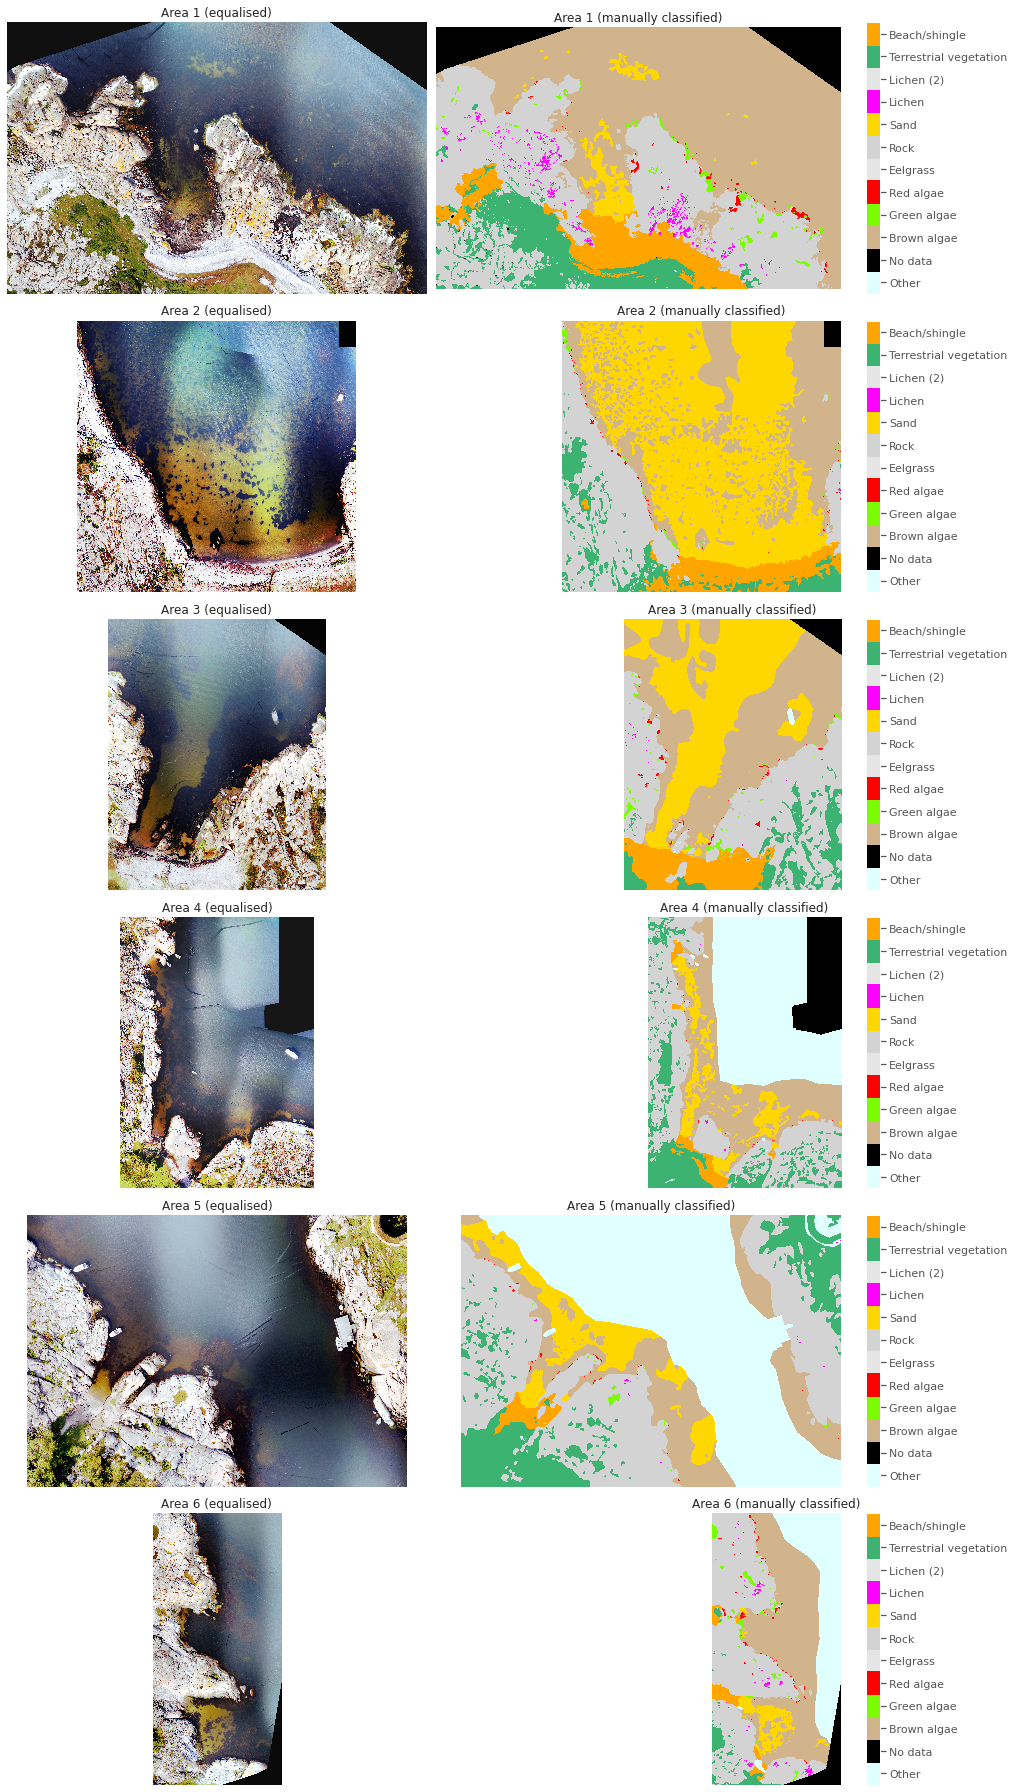

In [7]:
# Setup plot
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))

# Class codes
class_codes = {
    -1: "Other",
    0: "No data",
    1: "Brown algae",
    2: "Green algae",
    3: "Red algae",
    4: "Eelgrass",
    5: "Rock",
    6: "Sand",
    7: "Lichen",
    8: "Lichen (2)",
    9: "Terrestrial vegetation",
    10: "Beach/shingle",
}

# Define colours for classes. Ordered -1 to 10 (i.e. same as in 'class_codes', above)
cmap = colors.ListedColormap(
    [
        "lightcyan",
        "black",
        "tan",
        "lawngreen",
        "red",
        "none",
        "lightgrey",
        "gold",
        "magenta",
        "none",
        "mediumseagreen",
        "orange",
    ]
)
bounds = np.arange(-1.5, 11.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Loop over data
for area in range(1, 7):
    idx = area - 1

    # Paths to images
    raw_path = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif"
    man_path = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}_man_class.tif"

    # Read raw RGB bands to arrays
    band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
    band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
    band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)

    # Equalise images
    band1 = img_as_ubyte(exposure.equalize_hist(band1))
    band2 = img_as_ubyte(exposure.equalize_hist(band2))
    band3 = img_as_ubyte(exposure.equalize_hist(band3))

    raw_img = np.dstack((band1, band2, band3))

    # Read manually classified data (1 band only)
    man_img, ndv, man_epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)

    # Plot
    # Raw image
    axes[idx, 0].imshow(raw_img, interpolation="none")
    axes[idx, 0].set_title(f"Area {area} (equalised)", fontsize=12)

    # Manually classified
    img = axes[idx, 1].imshow(man_img, cmap=cmap, norm=norm, interpolation="none")
    axes[idx, 1].set_title(f"Area {area} (manually classified)", fontsize=12)

    # Turn off axes
    axes[idx, 0].axis("off")
    axes[idx, 1].axis("off")

    # Colourbar for manual dataset
    cb = plt.colorbar(img, ax=axes[idx, 1])
    labels = np.arange(-1, 11)
    cb.set_ticks(labels)
    cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()

## 3. Training on a single image

### 3.1. Get samples dataframe

In [8]:
# Area of interest
area = 1

# Get samples
df = utils.image_to_sample_df(area, equalise=False)

# Split into training and evaluation
cols = [str(i) for i in range(1, 9)]
X_train, X_eval, y_train, y_eval = train_test_split(
    df[cols],
    df["y"],
    test_size=0.4,
    random_state=42,
)

# Checking
assert len(X_train) == len(y_train)
assert len(X_eval) == len(y_eval)
print("Number of training samples:  ", len(X_train))
print("Number of evaluation samples:", len(X_eval))

df.head()

Number of training samples:   4217199
Number of evaluation samples: 2811467


y   1    2    3  4  5  6  7  8
0  1  80  106  121  2  3  3  4  2
1  1  81  108  123  2  3  3  4  2
2  1  76  101  116  2  3  3  4  2
3  1  81  105  121  2  3  3  4  2
4  1  81  105  120  2  3  3  4  2

### 3.2. Evaluate "basic" classifier

In [9]:
%%time

# Train on 60% of data
base_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
)
base_model.fit(X_train, y_train)

CPU times: user 1min 43s, sys: 2.16 s, total: 1min 45s
Wall time: 13 s


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1,
                       random_state=42)

In [10]:
%%time

# Predict for remaining 40% of data
base_preds = base_model.predict(X_eval)

CPU times: user 11.4 s, sys: 967 ms, total: 12.4 s
Wall time: 1.99 s


In [11]:
# Only use relevant labels from the training dataset
class_labels = [1, 2, 3, 5, 6, 7, 9, 10]
class_names = [class_codes[i] for i in class_labels]

utils.classification_report(
    y_eval,
    base_preds,
    class_labels,
    class_names,
)

Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.98      0.97      0.98   1251654
           Green algae       0.79      0.56      0.66     21688
             Red algae       0.77      0.42      0.54     10113
                  Rock       0.91      0.96      0.94    962213
                  Sand       0.85      0.81      0.83     72495
                Lichen       0.82      0.65      0.73     27937
Terrestrial vegetation       0.94      0.92      0.93    252276
         Beach/shingle       0.91      0.83      0.87    213091

              accuracy                           0.94   2811467
             macro avg       0.87      0.77      0.81   2811467
          weighted avg       0.94      0.94      0.94   2811467

Classification accuracy: 0.941333


<AxesSubplot:>

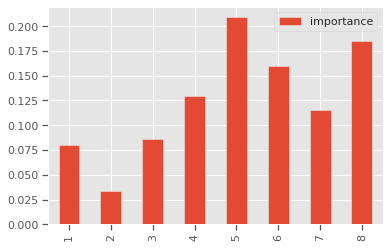

In [12]:
# Feature importances
imp_df = pd.DataFrame(
    {"importance": base_model.feature_importances_},
    index=range(1, 9),
)
imp_df.plot.bar()

### 3.3. Hyperparameter tuning

**Note:** The memory footprint of the forest increases linearly with the number of trees and exponentially with the `max_depth` parameter. The total size of the forest in memory can also easily become many times the size of the training dataset, so with large datasets (as here) it is easy to use *a lot* of memory. Including `max_depth=None`, as in the example below, will likely lead to very "deep" trees with a large memory footprint and/or memory errors.

If you do choose to run with `max_depth=None`, you can check the depth of the resulting forest using e.g.:

    depths = [tree.tree_.max_depth for tree in rf.estimators_]
    print(f"Mean tree depth in the Random Forest: {np.round(np.mean(depths))}.")
    print(f"Maximum tree depth in the Random Forest: {np.max(depths)}.")

In [13]:
# Number of trees in random forest
n_estimators = [10]

# Number of features to consider at every split
max_features = ["auto", "sqrt"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num=4)]
max_depth.append(None)

# Create the random grid
random_grid = {
    "max_features": max_features,
    "max_depth": max_depth,
    "n_estimators": n_estimators,
}

pprint(random_grid)

{'max_depth': [10, 40, 70, 100, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [10]}


In [ ]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_jobs=-1)

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [15]:
%%time

best = rf_random.best_estimator_

# Predict classes for remaining 40% of data
best_preds = best.predict(X_eval)

CPU times: user 19.7 s, sys: 974 ms, total: 20.7 s
Wall time: 2.85 s


In [16]:
print("The 'best' model identified has the following parameters:")
print(best)

utils.classification_report(
    y_eval,
    best_preds,
    class_labels,
    class_names,
)

The 'best' model identified has the following parameters:
RandomForestClassifier(max_depth=70, max_features='sqrt', n_estimators=10,
                       n_jobs=-1)
Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.98      0.98      0.98   1251654
           Green algae       0.78      0.66      0.71     21688
             Red algae       0.74      0.55      0.63     10113
                  Rock       0.93      0.96      0.94    962213
                  Sand       0.84      0.80      0.82     72495
                Lichen       0.83      0.66      0.73     27937
Terrestrial vegetation       0.95      0.92      0.93    252276
         Beach/shingle       0.91      0.86      0.88    213091

              accuracy                           0.95   2811467
             macro avg       0.87      0.80      0.83   2811467
          weighted avg       0.95      0.95      0.95   2811467

Classification accuracy: 0.946224


## 4. Train "basic" model using images 1, 2 and 6

In [17]:
# Read image data
df_list = []
for area in [1, 2, 6]:
    # With equalisation
    df = utils.image_to_sample_df(area, equalise=False)
    df_list.append(df)

df = pd.concat(df_list, axis="rows")
del df_list

print("Number of training samples:  ", len(df))

df.head()

Number of training samples:   25039284


y   1    2    3  4  5  6  7  8
0  1  80  106  121  2  3  3  4  2
1  1  81  108  123  2  3  3  4  2
2  1  76  101  116  2  3  3  4  2
3  1  81  105  121  2  3  3  4  2
4  1  81  105  120  2  3  3  4  2

In [18]:
%%time

# Train basic model
base_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
)

cols = [str(i) for i in range(1, 9)]
base_model.fit(df[cols], df["y"])

CPU times: user 8min 25s, sys: 12.3 s, total: 8min 37s
Wall time: 1min 3s


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1,
                       random_state=42)

<AxesSubplot:>

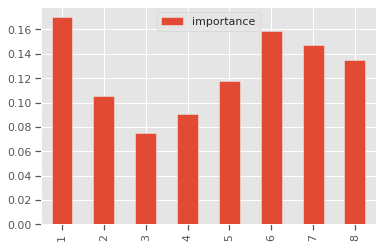

In [19]:
# Feature importances
imp_df = pd.DataFrame(
    {"importance": base_model.feature_importances_},
    index=range(1, 9),
)
imp_df.plot.bar()

## 5. Predict image 3

In [20]:
%%time

area = 3

im3_df = utils.image_to_sample_df(area, equalise=False)
base_preds = base_model.predict(im3_df[cols])

CPU times: user 22.9 s, sys: 2.9 s, total: 25.8 s
Wall time: 8.05 s


In [21]:
utils.classification_report(
    im3_df["y"],
    base_preds,
    class_labels,
    class_names,
)

Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.68      0.96      0.80   2153112
           Green algae       0.50      0.41      0.45     43001
             Red algae       0.53      0.11      0.19     20030
                  Rock       0.80      0.95      0.87   1931623
                  Sand       0.95      0.50      0.66   1911031
                Lichen       0.37      0.37      0.37      3436
Terrestrial vegetation       0.80      0.81      0.80    459539
         Beach/shingle       0.93      0.37      0.53    546144

              accuracy                           0.77   7067916
             macro avg       0.69      0.56      0.58   7067916
          weighted avg       0.81      0.77      0.75   7067916

Classification accuracy: 0.772822


In [22]:
# Convert maintaining original size (i.e. keep NoData)
im3_df = utils.image_to_sample_df(area, equalise=False, dropna=False)

# Predict image 3
im3_preds = base_model.predict(im3_df[cols])

# Set NoData in predictions
im3_preds[im3_df["y"] == 0] = 0

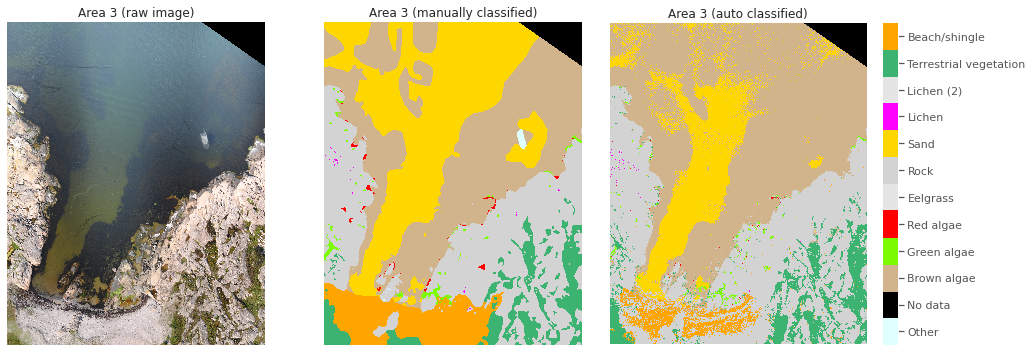

In [23]:
# Paths to images
raw_path = (
    f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif"
)
man_path = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}_man_class.tif"

# Read raw RGB bands to arrays
band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)
raw_img = np.dstack((band1, band2, band3))

# Read manual classification
man_img, ndv, epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)

# Reshape predictions
im3_preds = im3_preds.reshape(man_img.shape)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Raw image
axes[0].imshow(raw_img, interpolation="none")
axes[0].set_title(f"Area {area} (raw image)", fontsize=12)

# Manually classified
img = axes[1].imshow(man_img, cmap=cmap, norm=norm, interpolation="none")
axes[1].set_title(f"Area {area} (manually classified)", fontsize=12)

img = axes[2].imshow(im3_preds, cmap=cmap, norm=norm, interpolation="none")
axes[2].set_title(f"Area {area} (auto classified)", fontsize=12)

# Turn off axes
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

# Colourbar for manual dataset
cb = plt.colorbar(img, ax=axes[2])
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()

In [24]:
# Predict image 3 probs
im3_preds = base_model.predict_proba(im3_df[cols])

# Get max prob
im3_preds = im3_preds.max(axis=1)

# Set NoData in predictions
im3_preds[im3_df["y"] == 0] = np.nan

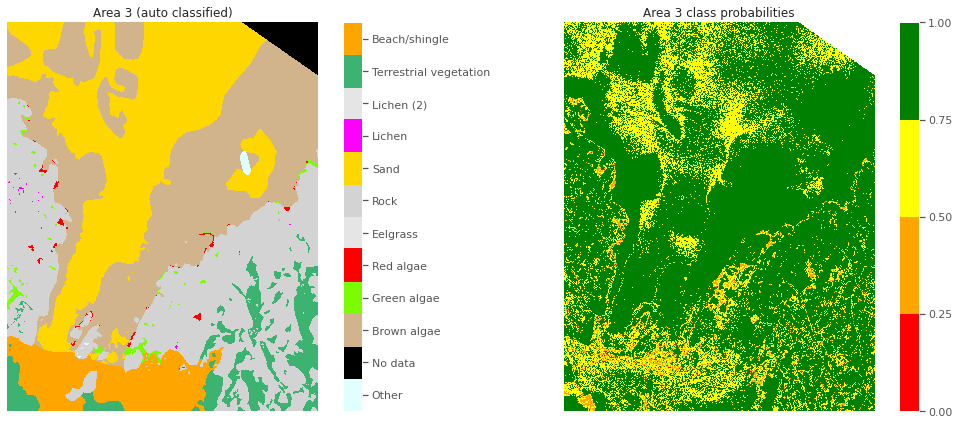

In [25]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

colours = ["red", "orange", "yellow", "green"]
n_bin = 4  # Discretizes the interpolation into bins
n_bins_ranges = [0, 0.25, 0.5, 0.75, 1]
cmap_name = "probs"

# Create the colormap
cmap2 = colors.LinearSegmentedColormap.from_list(cmap_name, colours, N=n_bin)
norm2 = colors.BoundaryNorm(n_bins_ranges, len(n_bins_ranges))

# Manually classified
img = axes[0].imshow(man_img, cmap=cmap, norm=norm, interpolation="none")
axes[0].set_title(f"Area {area} (auto classified)", fontsize=12)

# Reshape predictions
im3_preds = im3_preds.reshape(man_img.shape)
img2 = axes[1].imshow(im3_preds, cmap=cmap2, norm=norm2, interpolation="none")
axes[1].set_title(f"Area {area} class probabilities", fontsize=12)

# Turn off axes
axes[0].axis("off")
axes[1].axis("off")

# Colourbar for manual dataset
cb = plt.colorbar(img, ax=axes[0])
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))

# Colourbar for confidence
cb = plt.colorbar(img2, ax=axes[1])
cb.set_ticks(n_bins_ranges)
# cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()

## 6. Train basic model using all images

In [26]:
# Read image data
df_list = []
for area in range(1, 7):
    df = utils.image_to_sample_df(area, equalise=False)
    df_list.append(df)

df = pd.concat(df_list, axis="rows")
del df_list

print("Number of training samples:  ", len(df))

df.head()

Number of training samples:   49029319


y   1    2    3  4  5  6  7  8
0  1  80  106  121  2  3  3  4  2
1  1  81  108  123  2  3  3  4  2
2  1  76  101  116  2  3  3  4  2
3  1  81  105  121  2  3  3  4  2
4  1  81  105  120  2  3  3  4  2

In [27]:
%%time

# Train basic model
base_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
)

cols = [str(i) for i in range(1, 9)]
base_model.fit(df[cols], df["y"])

CPU times: user 18min 44s, sys: 1min 17s, total: 20min 1s
Wall time: 2min 28s


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1,
                       random_state=42)

<AxesSubplot:>

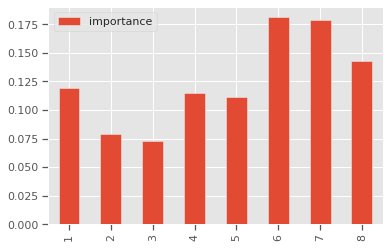

In [28]:
# Feature importances
imp_df = pd.DataFrame(
    {"importance": base_model.feature_importances_},
    index=range(1, 9),
)
imp_df.plot.bar()

In [29]:
out_path = r"/home/jovyan/shared/drones/frisk_oslofjord/base_model.joblib"
dump(base_model, out_path)

['/home/jovyan/shared/drones/frisk_oslofjord/base_model.joblib']

## 7. Predict "full" image

In [30]:
out_path = r"/home/jovyan/shared/drones/frisk_oslofjord/base_model.joblib"
base_model = load(out_path)

In [31]:
# Path to image
raw_path = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_all.tif"

# Container for data
data_dict = {}

# Read raw bands to arrays
for band in range(1, 9):
    data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=band)
    # data = img_as_ubyte(exposure.equalize_hist(data))
    data_dict[str(band)] = data.flatten()

# Build df
df = pd.DataFrame(data_dict)
del data_dict

df.reset_index(inplace=True, drop=True)

print(f"The dataset contains {len(df) / 1e6} million samples.")

The dataset contains 588.8 million samples.


In [32]:
%%time

# Predict
cols = [str(i) for i in range(1, 9)]

chunk_res = []
chunks = np.array_split(df, 30)

for chunk in chunks:
    chunk_res.append(base_model.predict(chunk[cols]))

all_preds = np.concatenate(chunk_res)

CPU times: user 21min 49s, sys: 3min 53s, total: 25min 43s
Wall time: 5min 12s


In [33]:
# Get snap grid
data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)

# Reshape predictions
all_preds = all_preds.reshape(data.shape)

# Set NoData in predictions
all_preds[data == 0] = 0

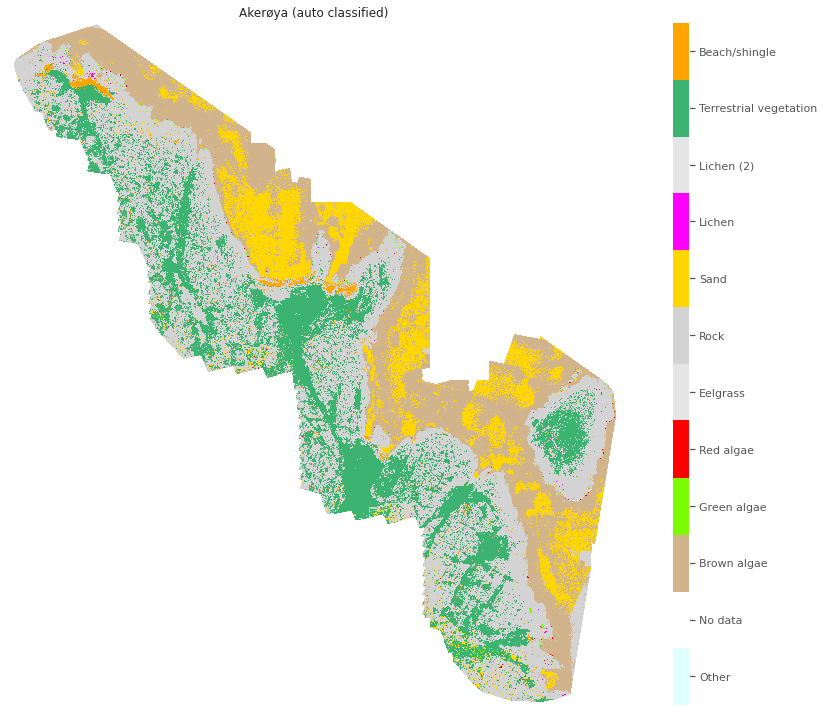

In [34]:
# Class codes
class_codes = {
    -1: "Other",
    0: "No data",
    1: "Brown algae",
    2: "Green algae",
    3: "Red algae",
    4: "Eelgrass",
    5: "Rock",
    6: "Sand",
    7: "Lichen",
    8: "Lichen (2)",
    9: "Terrestrial vegetation",
    10: "Beach/shingle",
}

# Define colours for classes. Same order as in 'class_codes'
cmap = colors.ListedColormap(
    [
        "lightcyan",
        "white",
        "tan",
        "lawngreen",
        "red",
        "none",
        "lightgrey",
        "gold",
        "magenta",
        "none",
        "mediumseagreen",
        "orange",
    ]
)
bounds = np.arange(-1.5, 11.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
img = ax.imshow(all_preds, cmap=cmap, norm=norm, interpolation="none")
ax.set_title(f"Akerøya (auto classified)", fontsize=12)
ax.axis("off")

cb = plt.colorbar(img, ax=ax, aspect=40)
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()

In [35]:
# Save to geotiff
out_path = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_all_auto_class.tif"
nivapy.spatial.array_to_gtiff(
    extent[0],
    extent[-1],
    0.05,
    out_path,
    all_preds,
    "+proj=utm +zone=32 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs",
    0,
    bit_depth="Int16",
)

## Image segmentation

https://github.com/machinalis/satimg/blob/master/object_based_image_analysis.ipynb

In [36]:
# from skimage.segmentation import felzenszwalb, quickshift

In [37]:
# area = 3

# # Containers for data
# data_list = []

# # Paths to images
# raw_path = (
#     f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{area}.tif"
# )

# # Read raw bands to arrays
# for band in range(1, 9):
#     data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=band)
#     data_list.append(data)

In [38]:
# img = np.dstack(data_list)
# rgb_img = np.dstack([img[:, :, 0], img[:, :, 1], img[:, :, 2]])
# plt.figure(figsize=(10, 10))
# plt.axis("off")
# plt.imshow(rgb_img, interpolation="none")

In [39]:
# band_segmentation = []
# for i in range(8):
#     band_segmentation.append(
#         felzenszwalb(img[:, :, i], scale=1000, sigma=0.8, min_size=100)
#     )

In [40]:
# const = [b.max() + 1 for b in band_segmentation]
# segmentation = band_segmentation[0]
# for i, s in enumerate(band_segmentation[1:]):
#     segmentation += s * np.prod(const[: i + 1])

# _, labels = np.unique(segmentation, return_inverse=True)
# segments_felz = labels.reshape(img.shape[:2])

In [41]:
# cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# axes[0].axis("off")
# axes[1].axis("off")
# axes[0].imshow(rgb_img, interpolation="none")
# axes[1].imshow(segments_felz, interpolation="none", cmap=cmap)

In [42]:
# segment_ids = np.unique(segments_felz)
# print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

In [43]:
# segment_ids

In [44]:
# from skimage.filters import rank
# from skimage.morphology import disk

# selem = disk(20)

# percentile_result = rank.mean_percentile(img[:, :, 0], selem=selem, p0=0.1, p1=0.9)
# bilateral_result = rank.mean_bilateral(img[:, :, 0], selem=selem, s0=500, s1=500)
# normal_result = rank.mean(img[:, :, 0], selem=selem)

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
# ax = axes.ravel()

# titles = ["Original", "Percentile mean", "Bilateral mean", "Local mean"]
# imgs = [img[:, :, 0], percentile_result, bilateral_result, normal_result]
# for n in range(0, len(imgs)):
#     ax[n].imshow(imgs[n], cmap=plt.cm.gray, interpolation="none")
#     ax[n].set_title(titles[n])
#     ax[n].axis("off")

# plt.tight_layout()